<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L06/CVaR_portfolio_optim_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Portfolio Return and Loss Calculation  

Extended

https://blog.quantinsti.com/cvar-expected-shortfall/

by R.Rocchetta 25/03/2025

This code analyzes the performance of a portfolio containing three assets:
* Amazon (AMZN), Tesla (TSLA), Apple (AAPL)

#### Steps:

1. **Data Download**:  Using `yfinance`, the historical daily closing of AMZN, TSLA, and AAPL are downloaded for the specified period

2. **Data Preparation**: Combine into a single DataFrame `df`
   
3. **Return Calculation**: The daily returns for each stock are calculated using the percentage change in closing prices. The returns are then negated (indicated by `-pct_change()`), as the script aims to compute losses (negative returns).
   
$$
\text{Percentage Change} = \frac{\text{Current Value} - \text{Previous Value}}{\text{Previous Value}} \times 100
$$



4. **Portfolio Construction**: a weighted portfolio created using the returns of the individual stocks. Returns (`Rp`) are calculated as the weighted sum of individual stock returns.

5. **Portfolio Value**: An initial portfolio value of 1,000,000 is set (`W`), and the cumulative returns are used to compute the portfolio value over time. The value is updated daily by multiplying the initial value by the cumulative product of (1 + portfolio returns).
   
6. **Loss Calculation**: The losses are computed as the difference between the initial portfolio value and the current portfolio value for each day, stored in the `L` column.

#### Output:
- The final DataFrame `df` contains:
  - Portfolio values (`Portfolio`)
  - Daily losses (`L`)
  - The weighted portfolio return on each day (`Rp`)

This analysis allows tracking how a portfolio of these three assets performs over time and calculates the losses incurred compared to the initial portfolio value.


In [21]:
import numpy as np
import pandas as pd # library for data analysis
import yfinance as yf  # we will load the data from here
from scipy.stats import norm
import matplotlib.pyplot as plt

In [34]:
# Download the data
amzn = yf.download('AMZN', '2023-11-30', '2024-11-30')
tsla = yf.download('TSLA', '2023-11-30', '2024-11-30')
aapl = yf.download('AAPL', '2023-11-30', '2024-11-30')

# Extract only closing prices
amzn_close = amzn['Close']
tsla_close = tsla['Close']
aapl_close = aapl['Close']

# Put all three closing prices together
df = pd.concat([amzn_close, tsla_close, aapl_close], axis=1)
df.columns = ['AMZN', 'TSLA', 'AAPL']

# Compute the returns as percentage of change
df['R1'] = -df['AMZN'].pct_change(fill_method=None)
df['R2'] = -df['TSLA'].pct_change(fill_method=None)
df['R3'] = -df['AAPL'].pct_change(fill_method=None)

df.head(1000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AMZN,TSLA,AAPL,R1,R2,R3
Date,,,,,,
2023-11-30,146.089996,240.080002,188.816376,NaN,NaN,NaN
2023-12-01,147.029999,238.830002,190.098663,-0.006434,0.005207,-0.006791
2023-12-04,144.839996,235.580002,188.299469,0.014895,0.013608,0.009465
2023-12-05,146.880005,238.720001,192.265656,-0.014085,-0.013329,-0.021063
2023-12-06,144.520004,239.369995,191.172226,0.016068,-0.002723,0.005687
...,...,...,...,...,...,...
2024-11-22,197.119995,352.559998,229.617538,0.006351,-0.038040,-0.005908
2024-11-25,201.449997,338.589996,232.614243,-0.021966,0.039624,-0.013051
2024-11-26,207.860001,338.230011,234.801834,-0.031819,0.001063,-0.009404


In [35]:
# Construct the portfolio returns column as a weighted sum of individual asset returns and weights
w = np.array([0.4, 0.3, 0.3])
df['Rp'] = (df[['R1', 'R2', 'R3']] * w).sum(axis=1)
df = df.drop(df.index[0])

# Add the Portfolio column with an initial value of 1,000,000 CHF
W = 1000000
df['Portfolio'] = W * (1 + df['Rp']).cumprod()

# Compute losses and add as a column to df
df['L'] = W - df['Portfolio']  # computed as initial investment - portfolio value
df[['Portfolio', 'Rp', 'L']].head(1000)

,Portfolio,Rp,L
Date,,,
2023-12-01,9.969509e+05,-0.003049,3049.139872
2023-12-04,1.009791e+06,0.012880,-9791.322883
2023-12-05,9.936837e+05,-0.015951,6316.285505
2023-12-06,1.000954e+06,0.007316,-953.793584
2023-12-07,9.872687e+05,-0.013672,12731.272508
...,...,...,...
2024-11-22,6.649541e+05,-0.010644,335045.868708
2024-11-25,6.644126e+05,-0.000814,335587.437625
2024-11-26,6.542935e+05,-0.015230,345706.498805


In [36]:
# Compute VaR(zero)
alpha = 0.05
VaR_level_w0 = df['L'].quantile(1-alpha)  # VaR_level = W - df['Portfolio'].quantile(alpha) is an equivalent way of expressing this
print('Value at Risk at confidence/probab level {:.2f} is: {:.2f} kCHF'.format(1-alpha, VaR_level_w0/1000))

Value at Risk at confidence/probab level 0.95 is: 325.54 kCHF


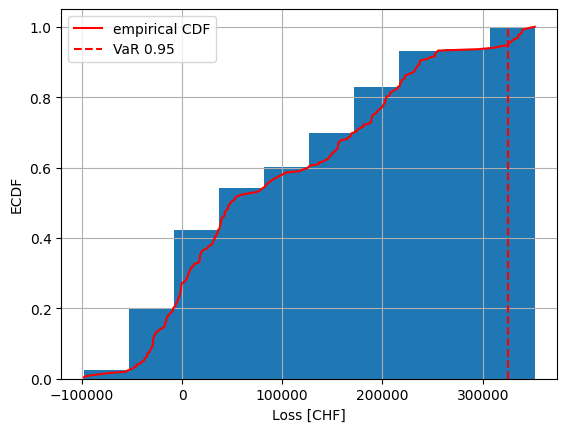

In [37]:
#@title visualize pdf and cdf of the loss function

def ecdf_data(data):
  x = np.sort(data)
  ecdf = np.arange(1, len(data)+1) / len(data)
  return x, ecdf


df['L'].hist(density=True, cumulative=True) # show cdf of daily losses
loss, ecdf = ecdf_data(df['L'])
plt.plot(loss, ecdf, 'r', label='empirical CDF')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='dashed', label=f'VaR {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend()
plt.show()

# Analytical vs empirical CVaR estimation

In [38]:
# Expected Shortfall analytical (assuming gaussian)
ES_analytic_w0 = df['L'].mean() + df['L'].std() * norm.pdf(norm.ppf(1-alpha)) / (alpha)
print('Expected Shortfall (analytical Gaussian assumption) is: {:.2f}'.format(ES_analytic_w0))

# Expected Shortfall (Conditional Value at Risk)
ES_empirical_w0 = df.loc[df['L'] > VaR_level_w0, 'L'].mean()
print('Expected Shortfall (empirical) is: {:.2f}'.format(ES_empirical_w0))

Expected Shortfall (analytical Gaussian assumption) is: 327669.06
Expected Shortfall (empirical) is: 336512.56


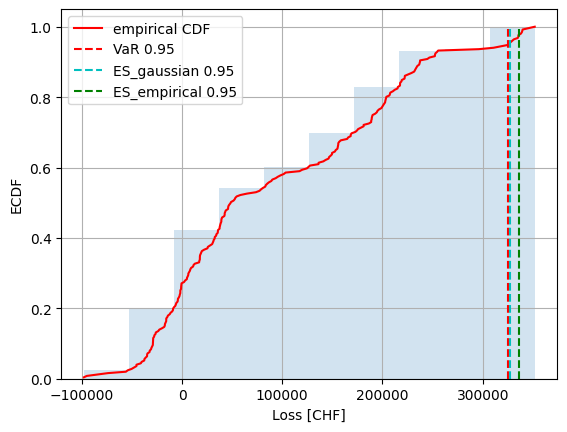

In [39]:
#@title visualize cdf of the loss function, VaR and ES for the base case
import matplotlib.pyplot as plt

Loss_base = df['L'].copy()
Loss_base.hist(density=True, cumulative=True, alpha=0.2) # show cdf of daily losses
loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='empirical CDF')
# add vertical lines for the VaR, Expected Shortfall (parametric and empirical)
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='dashed', label=f'VaR {1-alpha}')
plt.vlines(ES_analytic_w0, 0, 1, colors='c', linestyles='--', label=f'ES_gaussian {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='g', linestyles='dashed', label=f'ES_empirical {1-alpha}')

plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend()
plt.show()

In [40]:
###---###
# Greedy search.... use random portfolio generation to find a solution
# w = argmin Expected[Loss(w)], subject to a VaR(w) <= VaR_max constraint
###---###


 # Define optimization objective (minimize expected loss while constraining VaR)
def obj_fun_VaR(w, df, VaR_threshold):
    """Compute expected loss for given weights `w` and ensure VaR is below threshold."""
    df['Rp'] = (df[['R1', 'R2', 'R3']] * w).sum(axis=1)
    df['Portfolio'] = W * (1 + df['Rp']).cumprod()
    df['L'] = W - df['Portfolio']
    VaR = df['L'].quantile(1-alpha)
    expected_loss = df['L'].mean()

    if VaR <= VaR_threshold:
        return expected_loss
    else:
        return float('inf')  # Penalize solutions with VaR above the threshold

# Initial guess for weights
w0 = np.array([0.4, 0.3, 0.3])
# Define a VaR threshold....let see if we can do better than the base case w0.
VaR_threshold = VaR_level_w0  # This means we do not accept loss higher than kCHF at 5% probability of the base case, e.g. 320kCHF
best_w_VaR_EL = w0
min_expected_loss = float('inf')  # initialize a high objective function

# Number of samples for greedy search
num_samples = 2_000
for _ in range(num_samples):
    # Sample a new set of weights
    w_candidate = np.random.rand(3)
    w_candidate /= np.sum(w_candidate)  # Normalize to sum to 1

    # Compute expected loss and check VaR constraint
    expected_loss_candidate = obj_fun_VaR(w_candidate, df, VaR_threshold)

    # Update best weights if the current candidate has a lower expected loss and
    # satisfies the VaR constraint
    if expected_loss_candidate < min_expected_loss:
        min_expected_loss = expected_loss_candidate
        best_w_VaR_EL = w_candidate

# Results
print("\nExpected Loss Optimization with VaR Constraint (Greedy Search):")
print(f"Optimal weights: {best_w_VaR_EL.round(3)}")
print(f"Minimized Expected Loss: {min_expected_loss:.2f}")

# Calculate VaR for the optimal weights
df['Rp'] = (df[['R1', 'R2', 'R3']] * best_w_VaR_EL).sum(axis=1)
df['Portfolio'] = W * (1 + df['Rp']).cumprod()
df['L'] = W - df['Portfolio']
VaR_optimal = df['L'].quantile(1-alpha)
print('VaR for optimal weights: {:.2f} vs {:.2f} of the base case'.format(VaR_optimal, VaR_level_w0))


# Expected Shortfall analytical (assuming gaussian)
ES_analytic = df['L'].mean() + df['L'].std() * norm.pdf(norm.ppf(1-alpha)) / (alpha)
print('Expected Shortfall (analytical Gaussian assumption) is: {:.2f} vs {:.2f} of the base case'.format(ES_analytic, ES_analytic_w0))

# Expected Shortfall (Conditional Value at Risk)
ES_empirical = df.loc[df['L'] > VaR_optimal, 'L'].mean()
print('Expected Shortfall (empirical) is: {:.2f}  vs {:.2f} of the base case'.format(ES_empirical, ES_empirical_w0))




Expected Loss Optimization with VaR Constraint (Greedy Search):
Optimal weights: [0.008 0.486 0.506]
Minimized Expected Loss: 25278.23
VaR for optimal weights: 324960.52 vs 325539.40 of the base case
Expected Shortfall (analytical Gaussian assumption) is: 367949.68 vs 327669.06 of the base case
Expected Shortfall (empirical) is: 349587.51  vs 336512.56 of the base case


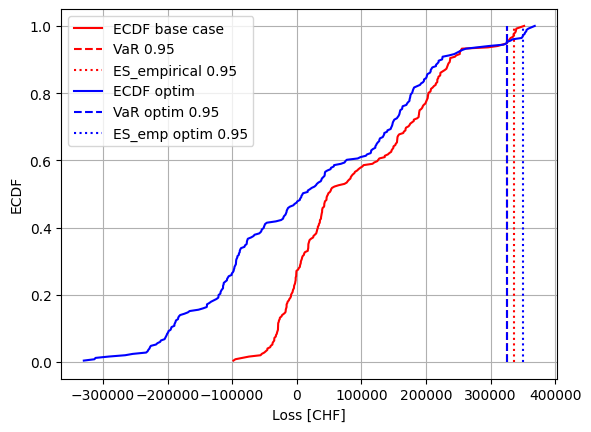

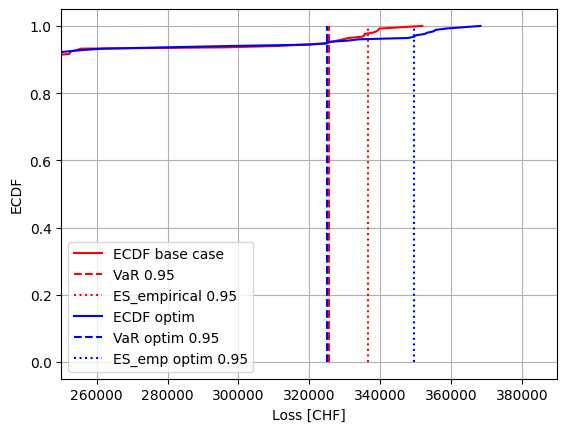

In [41]:
#@title visualize cdf of the loss function, VaR and ES for the optimized case
loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='--', label=f'VaR {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES_empirical {1-alpha}')

loss, ecdf = ecdf_data(df['L'])
plt.plot(loss, ecdf, 'b', label='ECDF optim ')
plt.vlines(VaR_optimal, 0, 1, colors='b', linestyles='--', label=f'VaR optim {1-alpha}')
plt.vlines(ES_empirical, 0, 1, colors='b', linestyles=':', label=f'ES_emp optim {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='upper left')
plt.grid()
plt.show()


loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='--', label=f'VaR {1-alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES_empirical {1-alpha}')

loss, ecdf = ecdf_data(df['L'])
plt.plot(loss, ecdf, 'b', label='ECDF optim ')
plt.vlines(VaR_optimal, 0, 1, colors='b', linestyles='--', label=f'VaR optim {1-alpha}')
plt.vlines(ES_empirical, 0, 1, colors='b', linestyles=':', label=f'ES_emp optim {1-alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='lower left')
plt.grid()
plt.xlim(250_000,390_000)
plt.show()

In [42]:
###---###
# Greedy search.... use random portfolio generation to find a solution
# w = argmin Expected[Loss(w)], subject to a CVaR(w) <= VaR_max constraint

# This time we search for a small expected short fall

###---###

 # Define optimization objective (minimize expected loss while constraining VaR)
def obj_fun_VaR(w, df, VaR_threshold):
    """Compute expected loss for given weights `w` and ensure VaR is below threshold."""
    df['Rp'] = (df[['R1', 'R2', 'R3']] * w).sum(axis=1)
    df['Portfolio'] = W * (1 + df['Rp']).cumprod()
    df['L'] = W - df['Portfolio']
    VaR = df['L'].quantile(1-alpha)
    ES_empirical = df.loc[df['L'] > VaR, 'L'].mean()
    expected_loss = df['L'].mean()

    if ES_empirical <= VaR_threshold:
        return expected_loss
    else:
        return float('inf')  # Penalize solutions with VaR above the threshold

# Initial guess for weights
w0 = np.array([0.4, 0.3, 0.3])
# Define a VaR threshold....let see if we can do better than the base case w0.
VaR_threshold = VaR_level_w0  # This means we do not accept loss higher than kCHF at 5% probability of the base case, e.g. 320kCHF
best_w_ES_EL = w0
min_expected_loss = float('inf')  # initialize a high objective function

# Number of samples for greedy search
num_samples = 2_000
for _ in range(num_samples):
    # Sample a new set of weights
    w_candidate = np.random.rand(3)
    w_candidate /= np.sum(w_candidate)  # Normalize to sum to 1

    # Compute expected loss and check VaR constraint
    expected_loss_candidate = obj_fun_VaR(w_candidate, df, VaR_threshold)

    # Update best weights if the current candidate has a lower expected loss and
    # satisfies the VaR constraint
    if expected_loss_candidate < min_expected_loss:
        min_expected_loss = expected_loss_candidate
        best_w_ES_EL = w_candidate

# Results
print("\nExpected Loss Optimization with CVaR Constraint (Greedy Search):")
print(f"Optimal weights: {best_w_VaR_EL.round(3)}")
print(f"Minimized Expected Loss: {min_expected_loss:.2f}")

# Calculate VaR for the optimal weights
df['Rp'] = (df[['R1', 'R2', 'R3']] * best_w_ES_EL).sum(axis=1)
df['Portfolio'] = W * (1 + df['Rp']).cumprod()
df['L'] = W - df['Portfolio']
VaR_optimal = df['L'].quantile(1-alpha)
print('VaR for optimal weights: {:.2f} vs {:.2f} of the base case'.format(VaR_optimal, VaR_level_w0))


# Expected Shortfall analytical (assuming gaussian)
ES_analytic = df['L'].mean() + df['L'].std() * norm.pdf(norm.ppf(1-alpha)) / (alpha)
print('Expected Shortfall (analytical Gaussian assumption) is: {:.2f} vs {:.2f} of the base case'.format(ES_analytic, ES_analytic_w0))

# Expected Shortfall (Conditional Value at Risk)
ES_empirical = df.loc[df['L'] > VaR_optimal, 'L'].mean()
print('Expected Shortfall (empirical) is: {:.2f}  vs {:.2f} of the base case'.format(ES_empirical, ES_empirical_w0))




Expected Loss Optimization with CVaR Constraint (Greedy Search):
Optimal weights: [0.008 0.486 0.506]
Minimized Expected Loss: 35107.36
VaR for optimal weights: 297734.36 vs 325539.40 of the base case
Expected Shortfall (analytical Gaussian assumption) is: 350234.81 vs 327669.06 of the base case
Expected Shortfall (empirical) is: 320129.81  vs 336512.56 of the base case


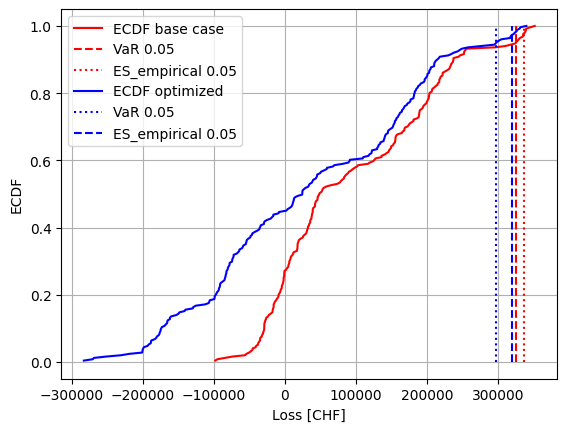

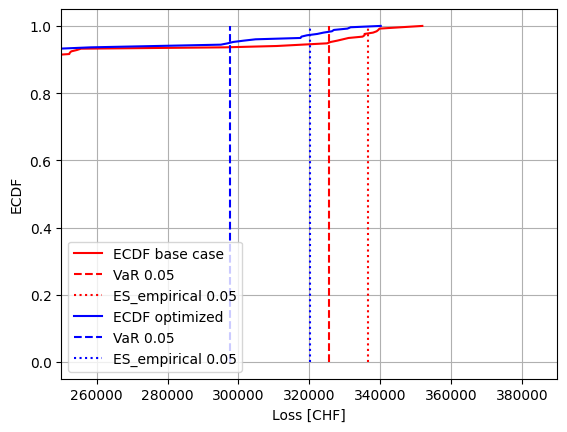

In [44]:
#@title visualize cdf of the loss function, VaR and ES for the optimized case
loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='--', label=f'VaR {alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES_empirical {alpha}')

loss, ecdf = ecdf_data(df['L'])
plt.plot(loss, ecdf, 'b', label='ECDF optimized')
plt.vlines(VaR_optimal, 0, 1, colors='b', linestyles=':', label=f'VaR {alpha}')
plt.vlines(ES_empirical, 0, 1, colors='b', linestyles='--', label=f'ES_empirical {alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='upper left')
plt.grid()
plt.show()

loss, ecdf = ecdf_data(Loss_base)
plt.plot(loss, ecdf, 'r', label='ECDF base case')
plt.vlines(VaR_level_w0, 0, 1, colors='r', linestyles='--', label=f'VaR {alpha}')
plt.vlines(ES_empirical_w0, 0, 1, colors='r', linestyles=':', label=f'ES_empirical {alpha}')

loss, ecdf = ecdf_data(df['L'])
plt.plot(loss, ecdf, 'b', label='ECDF optimized')
plt.vlines(VaR_optimal, 0, 1, colors='b', linestyles='--', label=f'VaR {alpha}')
plt.vlines(ES_empirical, 0, 1, colors='b', linestyles=':', label=f'ES_empirical {alpha}')
plt.xlabel('Loss [CHF]')
plt.ylabel('ECDF')
plt.legend(loc='lower left')
plt.grid()
plt.xlim(250_000,390_000)
plt.show()
